# Sensitivity to orientation of deep networks

This notebook reproduces subpanels of Fig 2, and also the supplementary material showing controls.

All trained networks are downloaded from Torchvision's distribution. In the controls, some networks are trained on a modified (rotated) version of ImageNet. Training scripts can be found in `train_rotated.py`. 

This script can be easily modified to test the orientation sensitivity of any Torchvision network. Simply change the 'model' in the relevant cell.

In [39]:
# Run imports 
import os
import sys, warnings
import numpy as np
import torch
from torchvision import models, transforms, utils
import torchvision.datasets as datasets
from matplotlib import pyplot as plt
import pickle
import pandas as pd
%matplotlib inline

from tqdm import tqdm as tqdm
from matplotlib import cm
import matplotlib as mpl

import seaborn as sns
sys.path.insert(0, "..")

In [41]:
if 'COLAB_GPU' in os.environ:
    print("Running on Google Colab, setting up environment")
    !mkdir -p /content/scripts  # Create the 'scripts' folder if it doesn't exist
    !mkdir -p /content/figures  # Create the 'figures' folder if it doesn't exist
    !mkdir -p /content/data  # Create the 'data' folder if it doesn't exist

    !wget -P /content/scripts https://raw.githubusercontent.com/KordingLab/ANN_psychophysics/master/scripts/fisher_calculators.py
    !wget -P /content/scripts https://raw.githubusercontent.com/KordingLab/ANN_psychophysics/master/scripts/orientation_stim.py
    !wget -P /content/scripts https://raw.githubusercontent.com/KordingLab/ANN_psychophysics/master/scripts/Alexnet_nooverlap.py
else:
    print("Not running on Google Colab, using local files")
    # Check if the folder exists
    figure_path = '../figures'
    data_path = '../data'

    if not os.path.isdir(figure_path):
        os.makedirs(figure_path)
    
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
cuda = torch.cuda.is_available()

if cuda:
    device = 'cuda'
if not cuda: 
    warnings.warn(f'CUDA is not available. Notebook will be run on CPU, which will be !! 🐢 Very Slow 🐢 !! Consider running on Google Colab')
    device = 'cpu'

from scripts.fisher_calculators import get_fisher_orientations
from scripts.orientation_stim import broadband_noise, gabor, grating, circular_mask

Not running on Google Colab, using local files


/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/2701974821.py:27: UserWarning: CUDA is not available. Notebook will be run on CPU, which will be !! 🐢 Very Slow 🐢 !! Consider running on Google Colab
  warnings.warn(f'CUDA is not available. Notebook will be run on CPU, which will be !! 🐢 Very Slow 🐢 !! Consider running on Google Colab')


In [21]:
# Configure plot parameters 
plt.style.use('seaborn-white', )
plt.rcParams['axes.labelsize'] =  25
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/403057613.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white', )



##### Define some generators to get Fisher for.

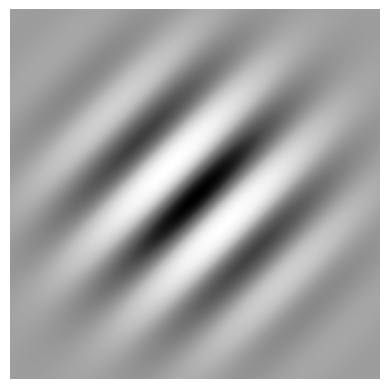

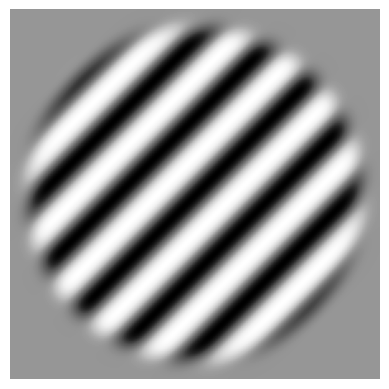

In [3]:
a = np.pi/4
generator_gabor = lambda a: torch.from_numpy(gabor(size=224, pixelsPerDegree=100, spatial_freq=2, spatial_phase=.1,
          orientation=-a-np.pi/2, contrast=1, sigma=.5, spatial_aspect_ratio=1)).expand(3,224,224)
plt.imshow(generator_gabor(a)[0])
plt.axis('off')

plt.show()


mask = circular_mask(224, 100, radius = 1, polarity_out=0,polarity_in=1,
                     if_filtered=True, filter_size=(50, 50), filter_width=5)
generator_grating = lambda a: torch.from_numpy(np.multiply(
                            grating(size=224, pixelsPerDegree=100, spatial_freq=3, spatial_phase=0,
            orientation=a, contrast=1),mask)).expand(3,224,224)
plt.imshow(generator_grating(a)[0])
plt.axis('off')
plt.show()


$+\Delta\theta$

In [4]:
def generator_gabor(a, spatial_freq=2, spatial_phase=0):
    return torch.from_numpy(gabor(size=224, pixelsPerDegree=100, spatial_freq=spatial_freq,
                                                   spatial_phase=spatial_phase,
              orientation=-a-np.pi/2, contrast=1, sigma=.5, spatial_aspect_ratio=1)).expand(3,224,224)

In [5]:


def plot_fisher(model, title, N=10, n_angles=40, n_phases=1, generator=None, scale=None, savefig=None):
    cs = sns.color_palette('plasma', N)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cs, len(cs))

    for i in tqdm(range(N)):
        sqrt_fishers_resnet = np.sqrt(torch.stack(get_fisher_orientations(model,i,n_angles, n_images=n_phases,
                                                              generator=generator_gabor, delta=1e-2)).cpu().numpy())
        normed =  sqrt_fishers_resnet/np.sum(sqrt_fishers_resnet)
        plt.plot(np.linspace(0, 180, n_angles),normed,"-", label = "Layer {}".format(i+1),c=cs[i])
    plt.ylim(bottom=0, top = max(max(normed),2*np.mean(normed)))
    plt.ylabel(r"$\sqrt{J(\theta)}$ (normalized)", fontsize = 15)
    plt.xlabel("Angle (º)", fontsize = 15)

    plt.xticks(np.linspace(0,180,5))
    #     plt.title("Layer {}".format(i), fontsize=15)
    #     plt.show()

    if scale is not None:
        plt.ylim(scale)

    plt.title(title, fontsize=20)
    clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))
    clb.ax.set_title('Layer')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    
def shuffle_all_weights(model):
    """Note: this destroys the model. In-place"""
    for m in model.parameters():
        
        #look at Conv2d
        if len(m.data.size()) > 3:
            n_channels = m.data.size()[0]
            
            for row in range(m.data.size()[2]):
                for col in range(m.data.size()[3]):
                    
                    # make it so each 
                    idx = torch.randperm(n_channels)
                    m.data[:,:,row,col] = m.data[idx,:,row,col]
                    
        elif len(m.data.size()) == 2:
            m.data = m.data[torch.randperm(m.data.size(0))]
            m.data = m.data[:, torch.randperm(m.data.size(1))]
        elif len(m.data.size()) == 1:
            m.data = m.data[torch.randperm(m.data.size(0))]
        elif len(m.data.size()) == 3:
            m.data = m.data[torch.randperm(m.data.size(0))]
            m.data = m.data[:, torch.randperm(m.data.size(1))]
            m.data = m.data[:, :, torch.randperm(m.data.size(2))]
                    
        
                        
    return model
            


## On Resnet

100%|██████████| 10/10 [06:49<00:00, 40.95s/it]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/3982037883.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))


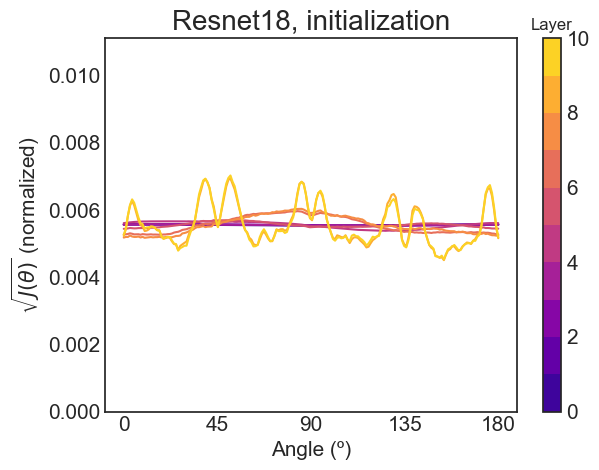

In [42]:
# initialization
model = models.resnet18(pretrained=False).to(device).eval()
plot_fisher(model, "Resnet18, initialization", 10, n_angles=180, n_phases=10)

/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [06:54<00:00, 41.42s/it]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/3982037883.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colo

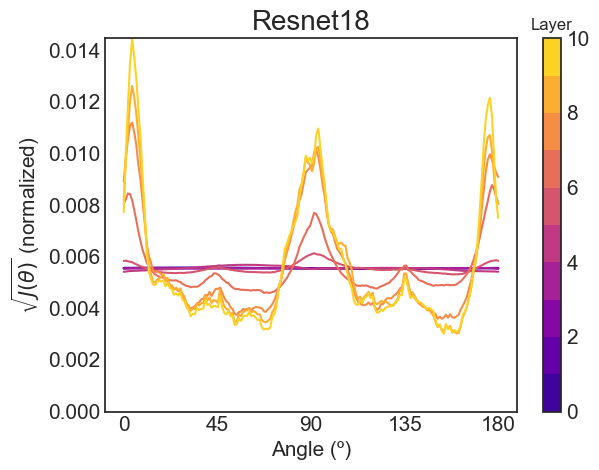

In [13]:
model = models.resnet18(pretrained=True).to(device).eval()

plot_fisher(model, "Resnet18", 10, n_angles=180, n_phases=10, savefig=None)


/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [06:45<00:00, 40.51s/it]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/3982037883.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colo

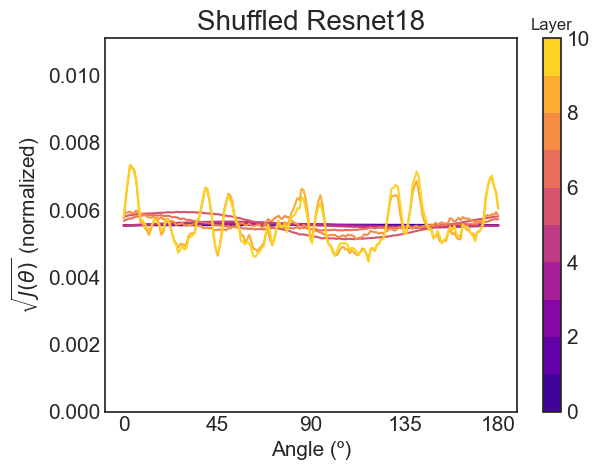

In [18]:
# shuffled weights
model = models.resnet18(pretrained=True).to(device).eval()

shuffle_all_weights(model)
plot_fisher(model, "Shuffled Resnet18", 10, n_angles=180, n_phases=10)


## Resnet34

In [ ]:
# cs = sns.color_palette('plasma', 10)
# model = models.resnet34(pretrained=True)
# # checkpoint = torch.load(which_alexnet)
# # model.load_state_dict(checkpoint['state_dict'])

# model.cuda().eval()
# plot_fisher(model, "Resnet34", 10, n_angles=180, n_phases=1, savefig="figures/resnet34.pdf")


## Resnet50

In [ ]:
# cs = sns.color_palette('plasma', 10)
# model = models.resnet50(pretrained=True)
# # checkpoint = torch.load(which_alexnet)
# # model.load_state_dict(checkpoint['state_dict'])

# model.cuda().eval()
# plot_fisher(model, "resnet50", 10, n_angles=180, n_phases=1, savefig="figures/resnet50.pdf")


## Now on VGG

In [ ]:
# cs = sns.color_palette('plasma', 21)

# model = models.vgg11(pretrained=True)
# # checkpoint = torch.load(which_alexnet)
# # model.load_state_dict(checkpoint['state_dict'])

# model.cuda().eval()
# plot_fisher(model, "vgg11", 20, n_angles=180, n_phases=1, savefig="figures/vgg11.pdf")


In [ ]:
# cs = sns.color_palette('plasma', 29)

# model = models.vgg11_bn(pretrained=True)
# # checkpoint = torch.load(which_alexnet)
# # model.load_state_dict(checkpoint['state_dict'])
# model.cuda().eval()
# plot_fisher(model, "vgg11_bn", 20, n_angles=180, n_phases=1, savefig="figures/vgg11_bn.pdf")


In [ ]:
# cs = sns.color_palette('plasma', 35)

# model = models.vgg13_bn(pretrained=True)
# # checkpoint = torch.load(which_alexnet)
# # model.load_state_dict(checkpoint['state_dict'])

# model.cuda().eval()
# plot_fisher(model, "vgg13_bn", 35, n_angles=180, n_phases=1, savefig="figures/vgg13bn.pdf")


/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  7%|▋         | 3/44 [11:29<2:36:57, 229.68s/it]


KeyboardInterrupt: 

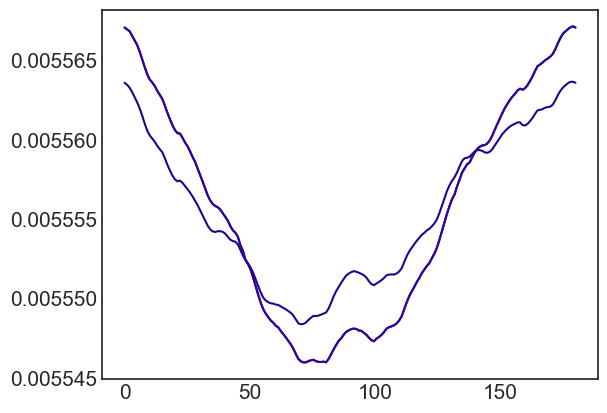

In [24]:

model = models.vgg16_bn(pretrained=False)
# checkpoint = torch.load(which_alexnet)
# model.load_state_dict(checkpoint['state_dict'])

model.to(device).eval()
    
plot_fisher(model, "vgg16_bn", 44, n_angles=180, n_phases=10)


In [25]:

model = models.vgg16_bn(pretrained=True)
# checkpoint = torch.load(which_alexnet)
# model.load_state_dict(checkpoint['state_dict'])

model.to(device).eval()
    
plot_fisher(model, "vgg16_bn", 44, n_angles=180, n_phases=10)


/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /Users/melian/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:51<00:00, 10.7MB/s] 
  0%|          | 0/44 [00:08<?, ?it/s][E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [26]:
model = models.vgg16_bn(pretrained=True)
shuffle_all_weights(model)

model.to(device).eval()

plot_fisher(model, "vgg16_bn_shuff", 44, n_angles=180, n_phases=10)


  0%|          | 0/44 [00:12<?, ?it/s]


KeyboardInterrupt: 

# Controls

These subpanels appear in the supplementary material. 

Note: Rotation controls require retraining a network on ImageNet, which can be expensive. The script for training a network on a modified ImageNet can be found as `train_rotated.py`. After training, snapshots of the model can be pointed to by this script.

## Alexnet

/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/melian/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:32<00:00, 7.49MB/s] 
100%|██████████| 12/12 [03:55<00:00, 19.63s/it]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/3982037883.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space fro

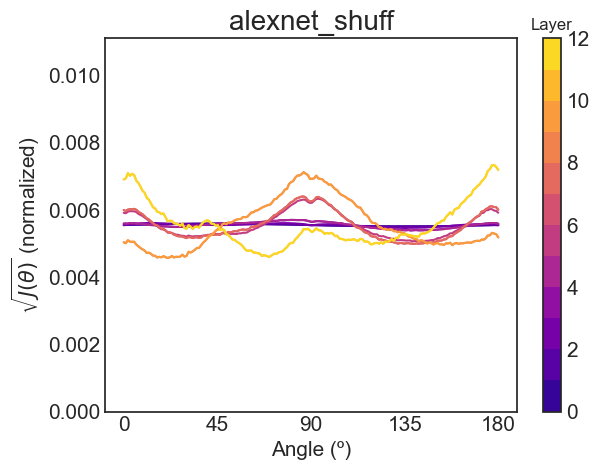

In [27]:
cs = sns.color_palette('plasma', 12)

model = models.alexnet(pretrained=True)
shuffle_all_weights(model)

model.to(device).eval()

plot_fisher(model, "alexnet_shuff", 12, n_angles=180, n_phases=10)

In [ ]:
cs = sns.color_palette('plasma', 12)

model = models.alexnet(pretrained=True)
shuffle_all_weights(model)

model.to(device).eval()

plot_fisher(model, "alexnet", 12, n_angles=180, n_phases=10)

In [ ]:
cs = sns.color_palette('plasma', 12)

models.alexnet(pretrained=False).to(device).eval()

plot_fisher(model, "alexnet_init", 12, n_angles=180, n_phases=10, scale=[.004,.008])

## Alexnet with no pooling.

What happens for Alexnet with no pooling? These require loading models defined in `Alexnet_nooverlap.py`.

In [28]:
from scripts.Alexnet_nooverlap import AlexNet_nooverlap, AlexNet_nopool

100%|██████████| 12/12 [03:51<00:00, 19.31s/it]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/3982037883.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))


FileNotFoundError: [Errno 2] No such file or directory: 'figures/alexnet_init_nooverlap2.pdf'

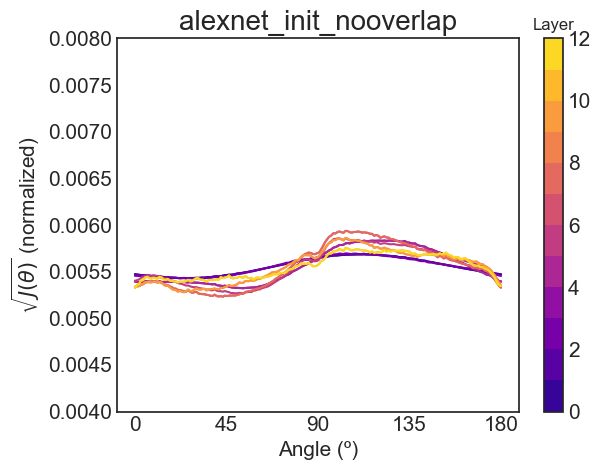

In [33]:
cs = sns.color_palette('plasma', 12)

model = AlexNet_nooverlap().to(device).eval()

plot_fisher(model, "alexnet_init_nooverlap", 12, n_angles=180, n_phases=10, scale=[.004,.008], savefig=os.path.join(figure_path, 'alexnet_init_nooverlap.pdf'))

100%|██████████| 12/12 [03:54<00:00, 19.52s/it]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/3982037883.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))


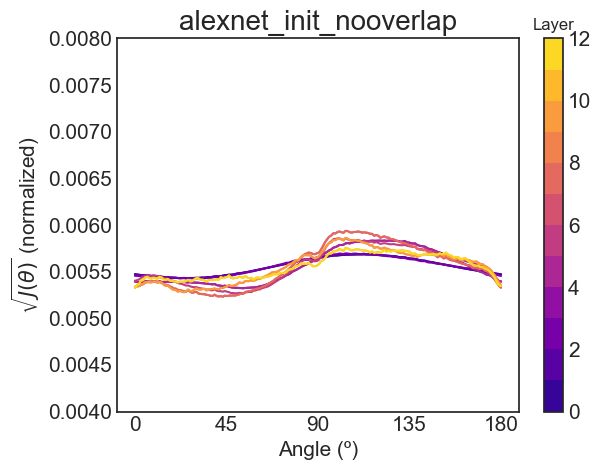

100%|██████████| 12/12 [04:30<00:00, 22.56s/it]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_32585/3982037883.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))


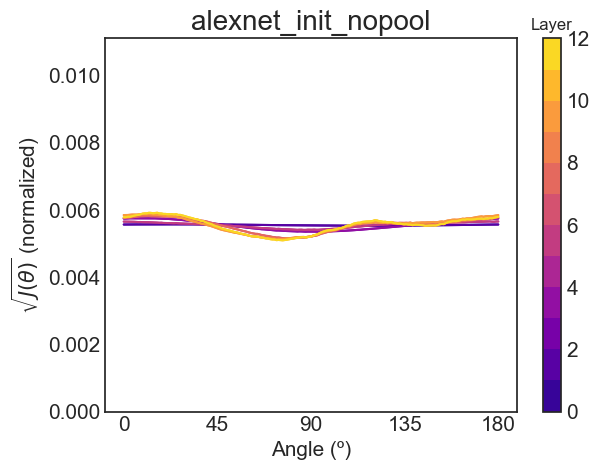

In [36]:
cs = sns.color_palette('plasma', 12)

model = AlexNet_nopool().to(device).eval()

plot_fisher(model, "alexnet_init_nopool", 12, n_angles=180, n_phases=10, savefig=os.path.join(figure_path, 'alexnet_init_nopool.pdf'))

In [ ]:
model = AlexNet_nooverlap().to(device).eval()

state_dict = models.alexnet(pretrained=True).state_dict()
model.load_state_dict(state_dict)
# shuffle_all_weights(model)


plot_fisher(model, "alexnet_nooverlap_shuff", 12, n_angles=180, n_phases=10, savefig=os.path.join(figure_path, 'alexnet_nooverlap_loaded.pdf'))


In [ ]:
model = AlexNet_nooverlap().to(device).eval()

state_dict = models.alexnet(pretrained=True).state_dict()
model.load_state_dict(state_dict)
shuffle_all_weights(model)

plot_fisher(model, "alexnet_nooverlap_shuff", 12, n_angles=180, n_phases=10, savefig=os.path.join(figure_path, 'alexnet_nooverlap_shuff.pdf'))


## Rotated

In [37]:

model = models.vgg16_bn(pretrained=False).to(device).eval()

checkpoint = torch.load('/data/abenjamin/DNN_illusions/vgg16_bn_rotated/checkpoint_epoch_90.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

plot_fisher(model, "rotated vgg", 44, n_angles=180, n_phases=10, savefig=os.path.join(figure_path, 'vgg16_bn_rotated.pdf'))


/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: '/data/abenjamin/DNN_illusions/vgg16_bn_rotated/checkpoint_epoch_90.pth.tar'

In [ ]:

model = models.resnet18(pretrained=False).to(device).eval()
checkpoint = torch.load('/data/abenjamin/DNN_illusions/resnet18_rotated/checkpoint_epoch_90.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

plot_fisher(model, "rotated Resnet18", 10, n_angles=180, n_phases=10, savefig=os.path.join(figure_path, 'resnet18_rotated.pdf'))


In [38]:
def plot_rotated_difference(model, model_rotated, N=10, n_angles=40, n_phases=1, generator=None, savefig=None):
    cs = sns.color_palette('plasma', N)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cs, len(cs))
    
    for i in tqdm(range(N)):
        sqrt_fishers_resnet = np.sqrt(torch.stack(get_fisher_orientations(model,i,n_angles, n_images=n_phases,
                                                              generator=generator_gabor, delta=1e-2, device=device)).cpu().numpy())
        normed =  sqrt_fishers_resnet/np.sum(sqrt_fishers_resnet)
        
        sqrt_fishers_resnet_rotated = np.sqrt(torch.stack(get_fisher_orientations(model_rotated,i,n_angles, n_images=n_phases,
                                                              generator=generator_gabor, delta=1e-2, device=device)).cpu().numpy())
        normed_rot =  sqrt_fishers_resnet_rotated/np.sum(sqrt_fishers_resnet_rotated)
        
        diff = normed_rot-normed
        
        plt.plot(np.linspace(0, 180, n_angles),diff,"-", label = "Layer {}".format(i+1),c=cs[i])
        
    plt.ylim(bottom=-max(max(diff),-min(diff)), top = max(max(diff),-min(diff)))
    plt.plot([0,180],[0,0],'k-')
    plt.ylabel(r"$\Delta\sqrt{J(\theta)}$ (normalized)", fontsize = 15)
    plt.xlabel("Angle (º)", fontsize = 15)
    plt.xticks(np.linspace(0,180,5))

    clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))
    clb.ax.set_title('Layer')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

In [ ]:
model = models.resnet18(pretrained=True).to(device).eval()
model_rotated = models.resnet18(pretrained=False).to(device).eval()


checkpoint = torch.load('/data/abenjamin/DNN_illusions/resnet18_rotated/checkpoint_epoch_90.pth.tar')
model_rotated.load_state_dict(checkpoint['state_dict'])

plot_rotated_difference(model, model_rotated, 10, n_angles=180, n_phases=10, savefig=os.path.join(figure_path, 'resnet18_rotated_diff.pdf'))


In [ ]:
model = models.vgg16_bn(pretrained=True).to(device).eval()
model_rotated = models.vgg16_bn(pretrained=False).to(device).eval()

checkpoint = torch.load('/data/abenjamin/DNN_illusions/vgg16_bn_rotated/checkpoint_epoch_90.pth.tar')
model_rotated.load_state_dict(checkpoint['state_dict'])

plot_rotated_difference(model, model_rotated, 44, n_angles=180, n_phases=10, savefig=os.path.join(figure_path, 'vgg16_bn_rotated_diff.pdf'))
